# 패키지 및 데이터 임포트

In [1]:
! pip install neuralprophet

/usr/local/lib/python3.8/dist-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/lib/python3.8/dist-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 KB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 KB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━

In [2]:
#패키지 임포트
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
import plotly.express as px
import numpy as np
set_log_level("ERROR")

In [3]:
from neuralprophet import NeuralProphet, set_log_level, torch_prophet

In [4]:
# #공휴일 불러오기
# import requests
# import json

In [8]:
# url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
# AUTH_KEY = '3coL3FArH/Ya0+3+S1U5kG0IC7pTsHiWs6D5OG+oCa6GL3LZd2rvVWtLeezTOz7PEkhfrKu5KQeQJz+SPGGquQ=='
# params = {
#     'solYear':str(2020),
#     'solMonth':str(1).zfill(2),
#     '_type':'json',
#     'ServiceKey' : AUTH_KEY
# }

# response =  requests.get(url,params=params)

In [9]:
# def getHolidays(year,month,key):
#     url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
#     params = {
#         'solYear':str(year),
#         'solMonth':str(month).zfill(2),
#         '_type':'json',
#         'ServiceKey' : key
#     }
#     res = requests.get(url,params=params)
#     dic = json.loads(res.text)
#     counts = dic['response']['body']['totalCount']
#     if counts < 1 :
#         return []
    
#     item =  dic['response']['body']['items']['item']
#     if counts == 1:
#         return [item]
    
#     return item

In [10]:
# holidays =[]
# for year in range(2018,2023):
#     for month in range(1,13):
#         holidays.extend(getHolidays(year,month,AUTH_KEY))
# holidays = pd.DataFrame(holidays).drop(['dateKind','isHoliday','seq'],axis=1)
# holidays.to_csv('data/holiday.csv')

In [19]:
#데이터불러오기
from datetime import datetime
import pandas as pd

train = pd.read_csv('data/train.csv')
gwang_df = pd.read_csv('data/train_gwangjin.csv')
dong_df = pd.read_csv('data/train_dongdaemoon.csv')
jung_df = pd.read_csv('data/train_jungnang.csv')
seong_df = pd.read_csv('data/train_seongdong.csv')

In [26]:
gwang_df.columns = pd.DataFrame(gwang_df.columns)[0].apply(lambda x: x.split('(')[0])
dong_df.columns = pd.DataFrame(dong_df.columns)[0].apply(lambda x: x.split('(')[0])
jung_df.columns = pd.DataFrame(jung_df.columns)[0].apply(lambda x: x.split('(')[0])
seong_df.columns = pd.DataFrame(seong_df.columns)[0].apply(lambda x: x.split('(')[0])

In [27]:
data=gwang_df[['일시','광진구','버스하차총승객수_size','평균기온','최저기온','최고기온','일강수량','평균 풍속','평균 상대습도']]

In [28]:
data['일시'] = data.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_179/2682147743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['일시'] = data.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))



# 데이터 전처리 및 모델 학습

In [30]:
#시계열 및 종속변수 이름 변경
data = data.rename(columns={"일시":"ds","광진구":"y"})

## ARX model

model에 대해 AR과정 그리고 X독립변수들에 대해서도 변수를 추가 활용하여 시계열 모델을 구축한 뒤, 이전 시간 단계의 데이터들을 모델이 학습하여 다음 시간 단계들에 대한 예측을 위해 사용해볼 것이다.

In [31]:
#X변수 정의
x_col_lst = ['버스하차총승객수_size', '평균기온', '최저기온', '최고기온', '일강수량',
       '평균 풍속', '평균 상대습도']

#Y변수 정의
y_col_lst = ['y']

In [41]:
#X변수, Y변수 분할
X=data[x_col_lst]
Y=data[y_col_lst]

#X변수들에 대한 lag 데이터 생성 (2 lag 까지만)
X_diff=X.diff()
X_diff.columns=X.columns+'_diff'

X_diff2=X.diff(periods=2)
X_diff2.columns=X.columns+'_diff2'

#Y변수들에 대한 lag 데이터 생성 (2 lag 까지만)
Y_diff=Y.diff()
Y_diff.columns=Y.columns+'_diff'

Y_diff2=Y.diff(periods=2)
Y_diff2.columns=Y.columns+'_diff2'

#X데이터 결합
X=pd.concat([X,X_diff,X_diff2],axis=1)

#Y데이터 결합
Y=pd.concat([Y,Y_diff,Y_diff2],axis=1)

#lag 데이터를 사용하므로 1행 ~ 2행 제거
#X=X.drop([0,1],axis=0)
#Y=Y.drop([0,1],axis=0)

#전체 데이터셋 생성
data_pret=pd.concat([data['ds'][2:],X,Y],axis=1)
data_pret=data_pret.reset_index(drop=True)

ds  버스하차총승객수_size  평균기온  최저기온  최고기온  일강수량  평균 풍속  평균 상대습도  \
0           NaT          716.0  -1.3  -5.1   3.8   0.0    1.4     39.1   
1           NaT          717.0  -1.8  -4.3   1.8   0.0    1.8     42.0   
2    2018-01-03          722.0  -4.7  -7.1  -0.4   0.0    2.2     42.3   
3    2018-01-04          718.0  -4.7  -8.7  -0.7   0.0    1.4     43.0   
4    2018-01-05          725.0  -3.0  -5.6   1.6   0.0    1.7     48.4   
...         ...            ...   ...   ...   ...   ...    ...      ...   
1456 2021-12-27          756.0  -7.6 -12.9  -3.9   0.0    1.7     60.9   
1457 2021-12-28          765.0  -4.1  -8.5  -0.9   0.0    2.2     73.8   
1458 2021-12-29          766.0   0.4  -3.8   5.9   0.2    2.6     72.9   
1459 2021-12-30          761.0  -3.9  -6.8   0.2   0.0    3.3     48.5   
1460 2021-12-31          769.0  -6.7  -8.8  -3.9   0.0    3.5     35.9   

      버스하차총승객수_size_diff  평균기온_diff  ...  버스하차총승객수_size_diff2  평균기온_diff2  \
0                    NaN        NaN  ...                  NaN         NaN   
1                    1.0       -0.5  ...                  NaN         NaN   
2                    5.0       -2.9  ...                  6.0        -3.4   
3                   -4.0        0.0  ...                  1.0        -2.9   
4                    7.0        1.7  ...                  3.0         1.7   
...                  ...        ...  ...                  ...         ...   
1456                -2.0        4.5  ...                 -3.0         4.1   
1457                 9.0        3.5  ...                  7.0         8.0   
1458                 1.0        4.5  ...                 10.0         8.0   
1459                -5.0       -4.3  ...                 -4.0         0.2   
1460                 8.0       -2.8  ...                  3.0        -7.1   

      최저기온_diff2  최고기온_diff2  일강수량_diff2  평균 풍속_diff2  평균 상대습도_diff2      y  \
0            NaN         NaN         NaN          NaN            NaN  0.592   
1            NaN         NaN         NaN          NaN            NaN  0.840   
2           -2.0        -4.2         0.0          0.8            3.2  0.828   
3           -4.4        -2.5         0.0         -0.4            1.0  0.792   
4            1.5         2.0         0.0         -0.5            6.1  0.818   
...          ...         ...         ...          ...            ...    ...   
1456         1.5         3.4         0.0         -2.2           18.5  3.830   
1457         7.0         6.4         0.0         -0.9           30.3  4.510   
1458         9.1         9.8         0.2          0.9           12.0  4.490   
1459         1.7         1.1         0.0          1.1          -25.3  4.444   
1460        -5.0        -9.8        -0.2          0.9          -37.0  3.616   

      y_diff  y_diff2  
0        NaN      NaN  
1      0.248      NaN  
2     -0.012    0.236  
3     -0.036   -0.048  
4      0.026   -0.010  
...      ...      ...  
1456   2.210    1.884  
1457   0.680    2.890  
1458  -0.020    0.660  
1459  -0.046   -0.066  
1460  -0.828   -0.874  

[1461 rows x 25 columns]

In [42]:
#train test split
cutoff = "2021-01-01" #데이터 분할 기준
train = data_pret[data_pret['ds']<cutoff]
test = data_pret[data_pret['ds']>=cutoff]

In [43]:
#최종독립변수 이름 생성
col_lst=data_pret.columns
col_lst=col_lst.drop(['ds','y'])
col_lst=list(col_lst)
col_lst

['버스하차총승객수_size',
 '평균기온',
 '최저기온',
 '최고기온',
 '일강수량',
 '평균 풍속',
 '평균 상대습도',
 '버스하차총승객수_size_diff',
 '평균기온_diff',
 '최저기온_diff',
 '최고기온_diff',
 '일강수량_diff',
 '평균 풍속_diff',
 '평균 상대습도_diff',
 '버스하차총승객수_size_diff2',
 '평균기온_diff2',
 '최저기온_diff2',
 '최고기온_diff2',
 '일강수량_diff2',
 '평균 풍속_diff2',
 '평균 상대습도_diff2',
 'y_diff',
 'y_diff2']

In [92]:
holiday = pd.read_csv('data/holiday.csv',index_col = 0)
holiday.columns = ['event','ds']
holiday['ds'] = holiday.ds.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
holiday['event'] = 'holiday'

In [93]:
holiday_train = holiday[holiday.ds<cutoff]

In [94]:
holiday_val = holiday[holiday.ds>=cutoff]

In [111]:
#multiplicative가 좋음 , growth는 off or linear 
m = NeuralProphet(
    
growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)
batch_size=128,#배치 사이즈 설정
epochs=200,#학습 횟수 설정
learning_rate=0.1, # 학습률 설정
daily_seasonality=False,
n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정
seasonality_mode='multiplicative',  # addaptive
# num_hidden_layers=4, #히든 레이어 수 설정
# d_hidden=128,
    
)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst, normalize="minmax") 
m.add_seasonality(name='year', period=365.25, fourier_order=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) #7
# m.add_seasonality(name='week', period=7, fourier_order=3)
m = m.add_events(["holiday"], lower_window=-1, upper_window=1)
history_df = m.create_df_with_events(train, holiday)
future_df = m.create_df_with_events(test, holiday)

#학습 수행
metrics = m.fit(history_df, freq='d')
future = m.make_future_dataframe(history_df, periods=365, n_historic_predictions=len(train))
train_pred = m.predict(future)
future_val = m.make_future_dataframe(future_df, periods=365, n_historic_predictions=len(test))
test_pred = m.predict(future_val)

# m = NeuralProphet(loss_func="MSE")
# m = m.add_events(["covid"])
# history_df = m.create_df_with_events(df, events_df)
# metrics = m.fit(history_df, freq="D")
# future = m.make_future_dataframe(df=history_df, events_df=events_df, periods=30, n_historic_predictions=len(df))
# forecast = m.predict(df=future)

Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

In [116]:
train_pred

ds      y     yhat1       ar1  lagged_regressor_버스하차총승객수_size1  \
0    2018-01-03  0.828       NaN       NaN                              NaN   
1    2018-01-04  0.792       NaN       NaN                              NaN   
2    2018-01-05  0.818  0.580628  0.569241                        10.965899   
3    2018-01-06  0.618  0.642858  0.542114                        10.978112   
4    2018-01-07  0.598  0.559898  0.568834                        11.054338   
...         ...    ...       ...       ...                              ...   
1090 2020-12-28  4.542  2.559449  2.270055                        11.044618   
1091 2020-12-29  3.694  3.571359  2.379544                        11.144439   
1092 2020-12-30  2.366  3.090434  3.148162                        11.204421   
1093 2020-12-31  2.366  3.858094  2.585502                        11.175261   
1094 2021-01-01    NaN  3.430247  1.622553                        11.193870   

      lagged_regressor_평균기온1  lagged_regressor_최저기온1  lagged_regressor_최고기온1  \
0                        NaN                     NaN                     NaN   
1                        NaN                     NaN                     NaN   
2                   2.561586               -3.377207               -0.258170   
3                   2.363028               -2.683419               -0.398316   
4                   2.969384               -3.824227               -0.402797   
...                      ...                     ...                     ...   
1090                3.891104               -4.707860               -0.613726   
1091                5.119502               -5.820030               -0.632984   
1092                6.223754               -7.244707               -0.186017   
1093                5.063762               -3.871415                0.197481   
1094                0.755530               -1.515562               -0.188645   

      lagged_regressor_일강수량1  lagged_regressor_평균 풍속1  ...  \
0                        NaN                      NaN  ...   
1                        NaN                      NaN  ...   
2                   0.000000                 0.268548  ...   
3                   0.000000                 0.190208  ...   
4                   0.000000                 0.212594  ...   
...                      ...                      ...  ...   
1090                0.000000                 0.249355  ...   
1091               -0.116757                 0.217392  ...   
1092                0.119520                 0.286096  ...   
1093                0.021151                 0.573818  ...   
1094                0.000000                 0.591444  ...   

      lagged_regressor_평균 상대습도_diff21  lagged_regressor_y_diff1  \
0                                 NaN                       NaN   
1                                 NaN                       NaN   
2                            0.989236                  2.097091   
3                            1.070974                  2.136219   
4                            1.021331                  2.000737   
...                               ...                       ...   
1090                         1.154285                  2.035648   
1091                         1.083084                  2.584621   
1092                         1.105187                  1.385053   
1093                         0.704609                  1.656420   
1094                         0.678057                  2.484966   

      lagged_regressor_y_diff21     trend  season_yearly  season_weekly  \
0                           NaN       NaN            NaN            NaN   
1                           NaN       NaN            NaN            NaN   
2                      1.243561 -6.086502       1.213804       0.064141   
3                      1.255459 -6.086502       1.261099       0.056863   
4                      1.232384 -6.086502       1.291712      -0.338529   
...                         ...       ...            ...            ...   
1090                   1.385

In [117]:
test_pred

ds      y     yhat1       ar1  lagged_regressor_버스하차총승객수_size1  \
0   2021-01-01  2.070       NaN       NaN                              NaN   
1   2021-01-02  2.062       NaN       NaN                              NaN   
2   2021-01-03  1.918  1.605104  1.419877                        11.153328   
3   2021-01-04  3.238  2.570164  1.419740                        11.095711   
4   2021-01-05  2.864  3.156141  1.263404                        11.055168   
..         ...    ...       ...       ...                              ...   
361 2021-12-28  4.510  5.053418  1.024035                        11.921651   
362 2021-12-29  4.490  4.440667  2.599786                        11.985790   
363 2021-12-30  4.444  5.390672  3.093649                        12.135042   
364 2021-12-31  3.616  4.891337  3.080956                        12.097698   
365 2022-01-01    NaN  3.912898  3.080169                        12.105053   

     lagged_regressor_평균기온1  lagged_regressor_최저기온1  lagged_regressor_최고기온1  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                  2.781836               -2.415138               -0.157757   
3                  2.555579               -2.937030               -0.214349   
4                  2.088048               -2.661272               -0.363573   
..                      ...                     ...                     ...   
361                0.159185               -0.601351               -0.284617   
362                1.417285               -1.329348               -0.352687   
363                2.188164               -2.677565               -0.649408   
364                4.357296               -4.457142               -0.118811   
365                3.091521               -3.486925               -0.057658   

     lagged_regressor_일강수량1  lagged_regressor_평균 풍속1  ...  \
0                       NaN                      NaN  ...   
1                       NaN                      NaN  ...   
2                  0.000000                 0.338858  ...   
3                  0.000000                 0.367647  ...   
4                  0.000000                 0.266942  ...   
..                      ...                      ...  ...   
361                0.000000                 0.407620  ...   
362                0.000000                 0.268528  ...   
363               -0.017963                 0.364435  ...   
364                0.021151                 0.471526  ...   
365                0.000000                 0.577029  ...   

     lagged_regressor_평균 상대습도_diff21  lagged_regressor_y_diff1  \
0                                NaN                       NaN   
1                                NaN                       NaN   
2                           0.724828                  2.191368   
3                           0.644660                  2.039535   
4                           1.164889                  2.842674   
..                               ...                       ...   
361                         1.254301                  3.358776   
362                         1.483491                  1.848084   
363                         1.193647                  1.911384   
364                         0.565481                  2.094109   
365                         0.340580                  1.692774   

     lagged_regressor_y_diff21     trend  season_yearly  season_weekly  \
0                          NaN       NaN            NaN            NaN   
1                          NaN       NaN            NaN            NaN   
2                     1.221619 -6.086502       1.091182      -0.338529   
3                     1.242357 -6.086502       1.167424       0.115576   
4                     1.418262 -6.086502       1.227190       0.192046   
..                         ...       ...            ...            ...   
361                   1.591293 -6.086502       0.269706       0.192046   
362     

In [51]:
metrics.tail(3)

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
197  1.834491  2.499115  0.025372          0.0    197  1.203452  1.689401   
198  1.834529  2.499126  0.025372          0.0    198  1.210711  1.705136   
199  1.834594  2.499152  0.025373          0.0    199  1.208792  1.698477   

         Loss  RegLoss  
197  0.009199      0.0  
198  0.009430      0.0  
199  0.009379      0.0

In [52]:
metrics.MAE_val.min()

1.7437362670898438

In [49]:
#metric 확인
#print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

MAE(Train):  1.132257342338562
MAE(Test):  1.8691569566726685


In [36]:
#metric 확인
#print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

MAE(Train):  1.1343477964401245
MAE(Test):  1.8281151056289673


In [53]:
#학습 선 그래프 생성
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

시각화 검증

Predicting: 9it [00:00, ?it/s]

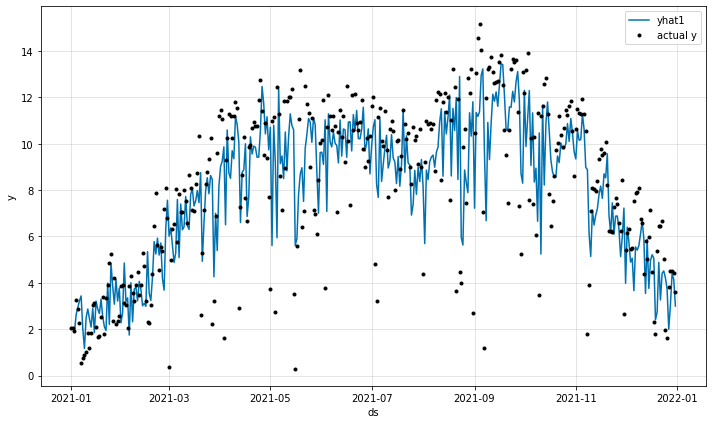

In [54]:
#yhat1과 실제값 시각화(lag 데이터 포함x)
forecast = m.predict(test)
fig = m.plot(forecast[['ds', 'y', 'yhat1']])

Predicting: 9it [00:00, ?it/s]

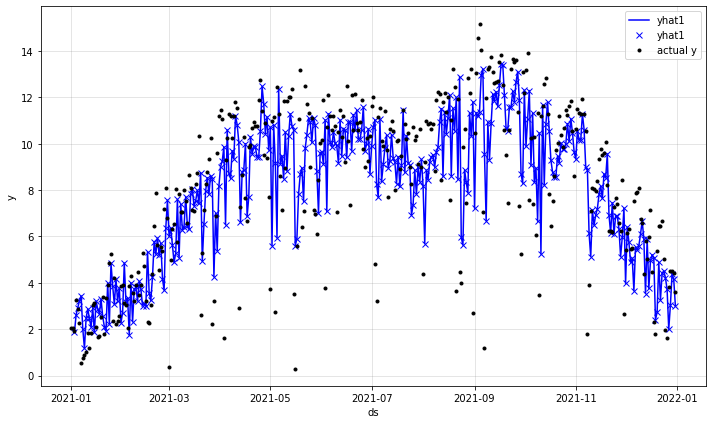

In [55]:
#yhat1과 실제값 시각화(lag 데이터 제거)
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [59]:
forecast.yhat1.max()

13.448141098022461

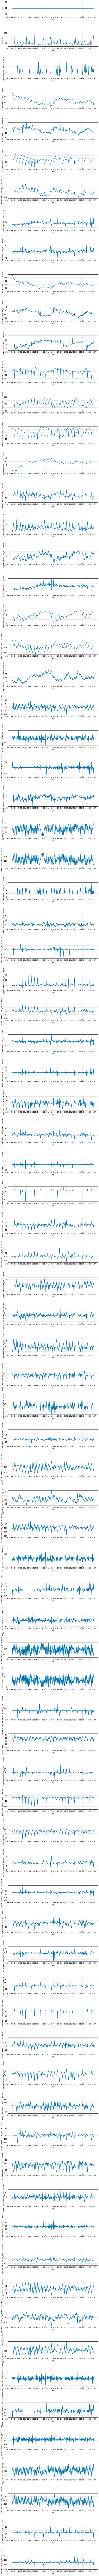

In [ ]:
#변수별 components 시각화
fig_comp = m.plot_components(forecast)

# 최적화 model : Using a Neural Network

이전 단계에서는 은닉층을 사용하지 않았지만 본 파트에서는 은닉층을 사용하여 이전 시간 단계의 데이터를 모델이 학습하여 다음 시간 단계에 대한 예측해보고 검증 데이터와 비교할 것이다.

In [ ]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=64,#배치 사이즈 설정

epochs=100,#학습 횟수 설정

learning_rate=0.1, # 학습률 설정

n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정

num_hidden_layers=4, #히든 레이어 수 설정

d_hidden=8,#은닉층에 대한 차원 수 설정


)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst, normalize="minmax") 

#학습 수행
metrics = m.fit(train, freq='h', validation_df=test, progress='plot')

In [ ]:
#metric 확인
print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  0.03682885334804119
MAE(Train):  46.88638314173217
MAE(Test):  42.725135803222656


In [ ]:
#학습 선 그래프 생성
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

# 시각화 검증

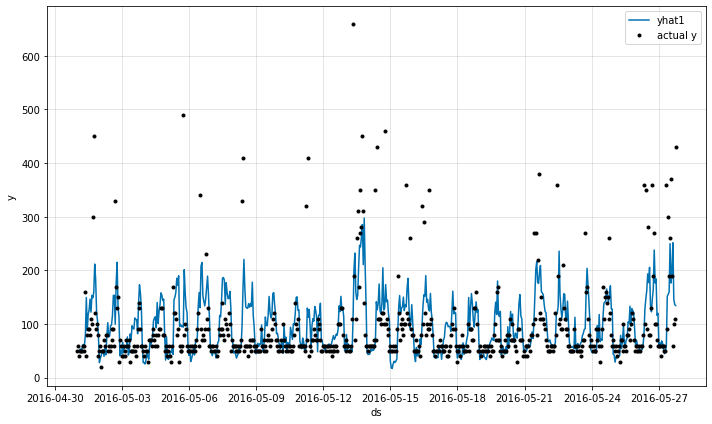

In [ ]:
#yhat1과 실제값 시각화(lag 데이터 포함x)
forecast = m.predict(test)
fig = m.plot(forecast[['ds', 'y', 'yhat1']])

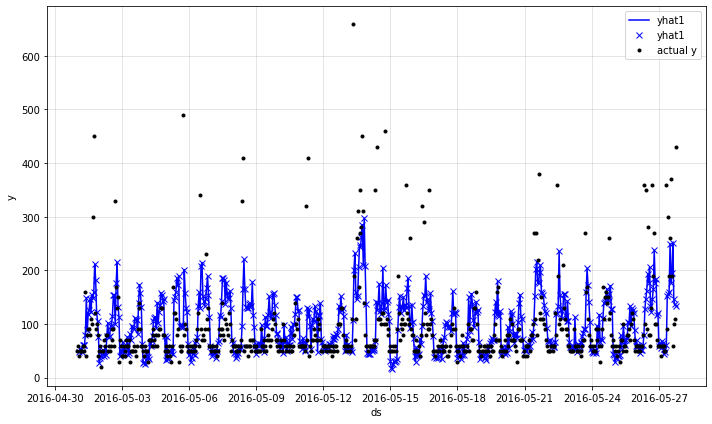

In [ ]:
#yhat1과 실제값 시각화(lag 데이터 포함O)
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

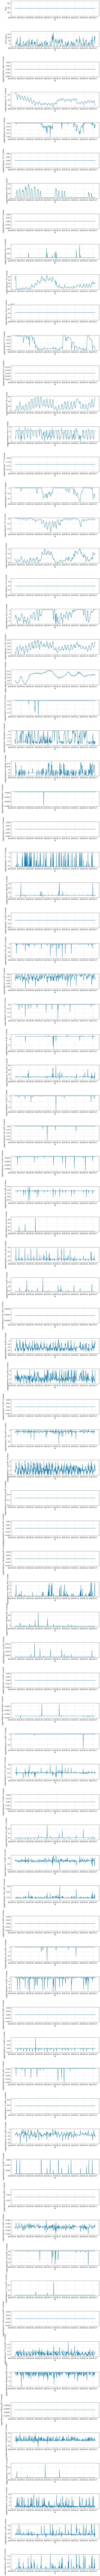

In [ ]:
#1-ahead에 대한 변수별 components 시각화
fig_comp = m.plot_components(forecast)

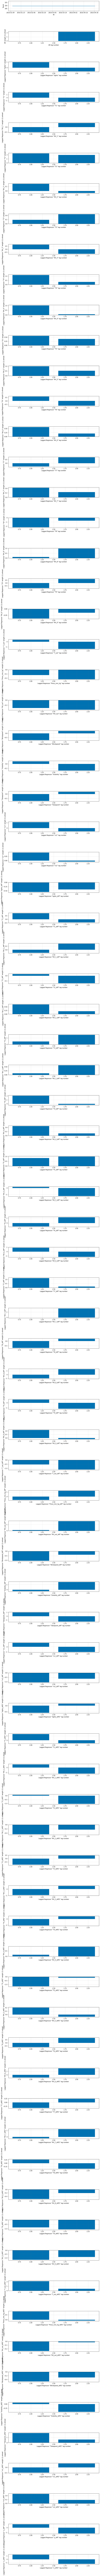

In [ ]:
#파라미터별 
fig_param = m.plot_parameters()

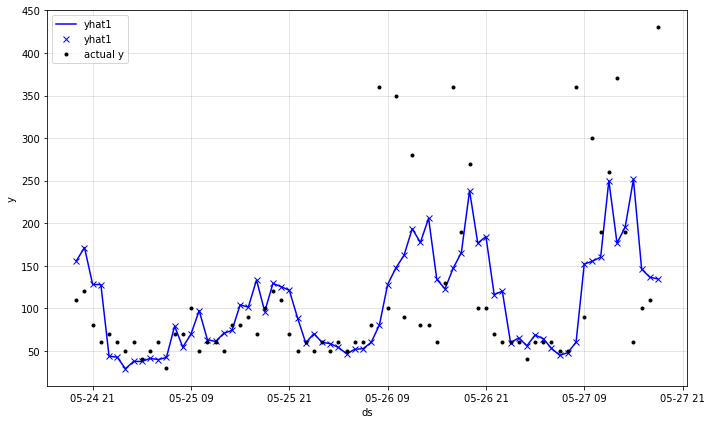

In [ ]:
#3일간 데이터 확인
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-3*24:]) 